# Sequence Prediction

Neural networks are powerful tools for text prediction, capable of learning patterns in language by analyzing large datasets. In this exercise, you'll use a neural network to predict whether  IMDB movie reviews are positive or negative based on their text. 

In [1]:
import os
import sys
import torch
import numpy as np
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print(torch.__version__)



2.1.0.dev20230610


## Tools to help us with text are plentiful, but a common one is going away
**TorchText** development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.

## We'll use the very popular tools from HuggingFace https://huggingface.co/

Note that these tools work with both pytorch and Tensorflow


In [3]:
try:
    import transformers
    import datasets
    import evaluate
    import accelerate
except:
    !pip install transformers datasets evaluate accelerate

    sys.exit()


/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may sti

# Text Data

Below we'll load the IMDB database tokenize it and setup our data loaders

In [4]:
from datasets import load_dataset
import torch.nn as nn
import torch.optim as optim

imdb = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
print(imdb.keys())

output=tokenizer(imdb['test'][0]['text'], truncation=True, max_length=100)

print("------------Original-------------")
print(imdb["test"][0])


print("------------Encoded-------------")
print(output['input_ids'])


print("------------Decoded-------------")
print(tokenizer.decode(output['input_ids']))



dict_keys(['train', 'test', 'unsupervised'])
------------Original-------------
{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and 

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=100)
imdb = imdb.map(tokenize_function, batched=True)
#imdb is a dictionary

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(imdb['train'].remove_columns("text"), shuffle=True, batch_size=256,collate_fn=data_collator)
test_dataloader = DataLoader(imdb['test'].remove_columns("text"), shuffle=False, batch_size=256,collate_fn=data_collator)

In [9]:
batch=next(iter(train_dataloader))

In [10]:
print(batch.keys())
print(batch['input_ids'].shape)
print(batch['input_ids'])

print(batch['labels'].shape)

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([256, 100])
tensor([[  101,  1045,  2253,  ...,  4302,  1998,   102],
        [  101,  1037,  2200,  ...,  1010,  2021,   102],
        [  101,  1999,  1037,  ..., 12908,  2831,   102],
        ...,
        [  101,  1999,  2857,  ...,  1996, 19318,   102],
        [  101,  2012,  2034,  ...,  1998,  2036,   102],
        [  101,  2990,  3490,  ...,  3084,  2149,   102]])
torch.Size([256])


In [13]:
vocab_size=len(tokenizer.vocab)
vocab_size

30522

In [14]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)        
        self.rnn = nn.LSTM(embed_dim, embed_dim, batch_first=True,dropout=0.0)
        self.fc = nn.Linear(embed_dim, output_dim)
    
    def forward(self, x):
        embedding=self.embedding(x)
        output, states = self.rnn(embedding)
        output=self.fc(output[:,-1,:]).squeeze()
        return torch.nn.functional.sigmoid(output)



In [16]:
from tqdm import tqdm
from torchmetrics.classification import Accuracy, F1Score

n_epochs=8
test_loss=[]
train_loss=[]

model=SimpleRNNClassifier(vocab_size=vocab_size,embed_dim=50,output_dim=1,pad_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn= torch.nn.BCELoss()

for epoch in range(n_epochs):
    model.train()
    _loss=[]
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        output=model(batch['input_ids'])
        loss = loss_fn(output, batch['labels'].float())
        loss.backward()
        optimizer.step()
        _loss.append(loss.item())
    train_loss.append(np.mean(_loss[-10:]))
    model.eval()
    with torch.no_grad():
        test_pred,test_label=zip(*[(model(test_batch['input_ids']),test_batch['labels']) for test_batch in test_dataloader])
        test_pred=torch.cat(test_pred)
        test_label=torch.cat(test_label).float()
        test_loss.append(loss_fn(test_pred,test_label).item())
        
    print("Loss",train_loss[-1],"Val Loss",test_loss[-1])




100%|██████████| 98/98 [00:09<00:00, 10.31it/s]


Loss 0.6901914000511169 Val Loss 0.6914037466049194


100%|██████████| 98/98 [00:10<00:00,  9.75it/s]


Loss 0.6430858314037323 Val Loss 0.6473978161811829


100%|██████████| 98/98 [00:09<00:00,  9.86it/s]


Loss 0.5874919295310974 Val Loss 0.6044509410858154


100%|██████████| 98/98 [00:09<00:00,  9.80it/s]


Loss 0.5220450848340988 Val Loss 0.5627480745315552


100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Loss 0.4659455895423889 Val Loss 0.5351859331130981


100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


Loss 0.48703823387622835 Val Loss 0.5403647422790527


100%|██████████| 98/98 [00:09<00:00, 10.78it/s]


Loss 0.6307250738143921 Val Loss 0.6407356858253479


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Loss 0.5823529064655304 Val Loss 0.6258018612861633


Accuracy tensor(0.6726)
F1 tensor(0.6351)


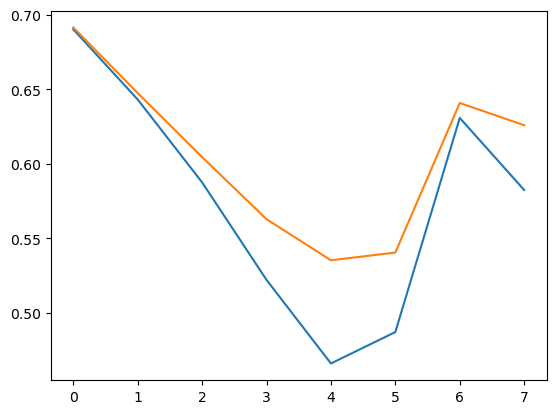

In [17]:
import matplotlib.pyplot as plt
accuracy = Accuracy(task="binary")
f1_score = F1Score(task="binary")

print("Accuracy",accuracy(test_pred,test_label))
print("F1",f1_score(test_pred,test_label))

plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

# Exercise #1

* Try it yourself, make up a short review of any movie you've seen and see what the model above predicts!

## Steps
* Write your review
* Tokenize your review
* Predict!


In [43]:
my_review = "Cheaper by the Dozen 2 is a very timeless movie. It is light-hearted and accurately captures the feeling of summer, from the perspectives of younger children, teenagers, and adults."
tokenized_review = tokenizer(my_review)
tokenized_review

{'input_ids': [101, 16269, 2011, 1996, 6474, 1016, 2003, 1037, 2200, 27768, 3185, 1012, 2009, 2003, 2422, 1011, 18627, 1998, 14125, 19566, 1996, 3110, 1997, 2621, 1010, 2013, 1996, 15251, 1997, 3920, 2336, 1010, 12908, 1010, 1998, 6001, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
# torch.tensor([tokenized_review['input_ids']]).shape
model(torch.tensor([tokenized_review['input_ids']])).item()

0.7667133808135986

# Question did the model predict correctly? 

Yes, it predicted my review as a positive one.

# Exercise #2
There are a number of things that could improve the performance of the model above

1. The tokenizer is truncating to 100 tokens
2. Their are many other kinds of models RNNs, GRUs, Transformers
3. The model  only has one fully connected layer
4. What devices is the code on?

I've replicated the code below, and I would like you to try and improve the model by exploring at at least one of these issues

## 510 - I would like you to achieve an accuracy of ~78% 
**Bonus** go for even higher. Note that this isn't easy. As a hint see: [Fine Tuning Example](https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
my_imdb = load_dataset("imdb")
my_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def my_tokenize_function(examples):
    return my_tokenizer(examples["text"], truncation=True, max_length=100)
    
my_imdb = my_imdb.map(my_tokenize_function, batched=True)

vocab_size = my_tokenizer.vocab_size

data_collator = DataCollatorWithPadding(tokenizer=my_tokenizer)

my_train_dataloader = DataLoader(my_imdb['train'].remove_columns("text"), shuffle=True, batch_size=256,collate_fn=data_collator)
my_test_dataloader = DataLoader(my_imdb['test'].remove_columns("text"), shuffle=False, batch_size=256,collate_fn=data_collator)



n_epochs=5
test_loss=[]
train_loss=[]


class MyClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)        
        self.rnn = nn.LSTM(embed_dim, embed_dim, batch_first=True,dropout=0.0)
        
        self.fc = nn.Linear(embed_dim, output_dim)
    
    def forward(self, x):
        embedding=self.embedding(x)
        output, states = self.rnn(embedding)
        output=self.fc(output[:,-1,:]).squeeze()
        return torch.nn.functional.sigmoid(output)



my_model=MyClassifier(vocab_size=vocab_size,embed_dim=50,output_dim=1,pad_index=0)
my_model.to(device)
optimizer = optim.Adam(my_model.parameters(), lr=0.0005)
loss_fn= torch.nn.BCELoss()

for epoch in range(n_epochs):
    my_model.train()
    _loss=[]
    for batch in tqdm(my_train_dataloader):
        batch.to(device)
        optimizer.zero_grad()
        output=my_model(batch['input_ids'])
        loss = loss_fn(output, batch['labels'].float())
        loss.backward()
        optimizer.step()
        _loss.append(loss.item())
    train_loss.append(np.mean(_loss[-10:]))
    my_model.eval()
    with torch.no_grad():
        for test_batch in my_test_dataloader:
            test_batch = test_batch.to(device)
            test_pred,test_label=zip((my_model(test_batch['input_ids']),test_batch['labels']))
        test_pred=torch.cat(test_pred)
        test_label=torch.cat(test_label).float()
        test_loss.append(loss_fn(test_pred,test_label).item())
        
    print("Loss",train_loss[-1],"Val Loss",test_loss[-1])

100%|██████████| 98/98 [00:02<00:00, 37.41it/s]


Loss 0.6919757544994354 Val Loss 0.7149549126625061


100%|██████████| 98/98 [00:02<00:00, 40.50it/s]


Loss 0.6763667643070221 Val Loss 0.6372026205062866


100%|██████████| 98/98 [00:02<00:00, 40.52it/s]


Loss 0.6385047018527985 Val Loss 0.5910970568656921


100%|██████████| 98/98 [00:02<00:00, 40.40it/s]


Loss 0.5938753962516785 Val Loss 0.5329702496528625


100%|██████████| 98/98 [00:02<00:00, 40.43it/s]


Loss 0.5597018361091614 Val Loss 0.47109439969062805


# Make sure your accuracy shows up below

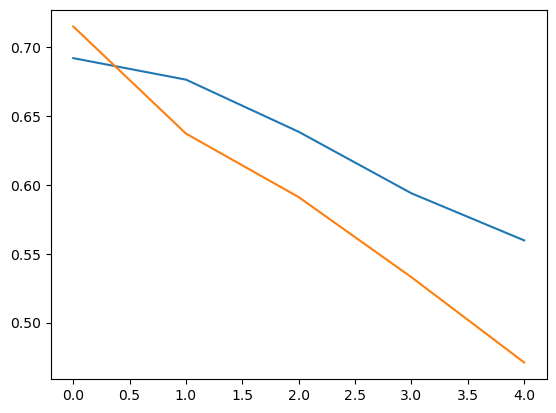

Accuracy: 0.8392857142857143
F1 Score: 0.9126213592233009


In [81]:
# print("Accuracy",accuracy(test_pred,test_label))
# print("F1",f1_score(test_pred,test_label))

plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

# Move tensors to CPU before converting to NumPy arrays
test_pred_cpu = test_pred.cpu().detach().numpy()
test_label_cpu = test_label.cpu().detach().numpy()

# Calculate accuracy and F1 score
accuracy_score_value = accuracy_score(test_label_cpu, test_pred_cpu.round())
f1 = f1_score(test_label_cpu, test_pred_cpu.round())

print("Accuracy:", accuracy_score_value)
print("F1 Score:", f1)

# Q. What did you fix and how well did it work?

I changed model to cuda, and had to move the tensors to CPU before converting them to numpy arrays. I also decreased the batch size from .001 to .0005, which seemed to improve the model. 